In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchmetrics import Accuracy, Precision, Recall, F1Score



torch.manual_seed(8)
torch.cuda.manual_seed_all(8)  
class CNNLSTM(nn.Module):
    def __init__(self, num_features, dropout=0.5, lstm_hidden_dim=128, num_layers=1):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout)
        self.num_flatten_features = 32 * (num_features // 4)
        self.lstm = nn.LSTM(input_size=self.num_flatten_features, hidden_size=lstm_hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.reshape(x.size(0), -1, self.num_flatten_features)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [88]:
# Load the data
data = pd.read_csv('normalised_features_with_diagnosis.csv')
class_mapping = {
    'healthy': 0,
    'positive_mild': 1,
    'no_resp_illness_exposed': 0,
    'resp_illness_not_identified': 0,
    'positive_moderate': 1,
    'recovered_full': 0,
    'positive_asymp': 1
}
data['diagnosis'] = data['diagnosis'].map(class_mapping)
features = data.drop(['filename', 'diagnosis'], axis=1)
labels = data['diagnosis'].values

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)
X_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=3)

# Data loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

In [89]:
# Setup the device and criterion
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()

# Hyperparameters for grid search
dropout_options = [0.3, 0.5, 0.7]
hidden_dim_options = [64, 128, 256]
num_layers_options = [1, 2, 3]

best_val_loss = float('inf')
best_model_settings = {}

# Initialize lists to hold the best losses
best_training_losses = []
best_validation_losses = []

for dropout in dropout_options:
    for hidden_dim in hidden_dim_options:
        for num_layers in num_layers_options:
            model = CNNLSTM(num_features=24, dropout=dropout, lstm_hidden_dim=hidden_dim, num_layers=num_layers).to(device)
            optimizer = Adam(model.parameters(), lr=0.001)
            
            temp_training_losses = []
            temp_validation_losses = []
            
            for epoch in range(15):
                model.train()
                total_train_loss = 0
                for data, target in train_loader:
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()
                    total_train_loss += loss.item()

                avg_train_loss = total_train_loss / len(train_loader)
                temp_training_losses.append(avg_train_loss)

                model.eval()
                total_val_loss = 0
                with torch.no_grad():
                    for data, target in val_loader:
                        data, target = data.to(device), target.to(device)
                        output = model(data)
                        val_loss = criterion(output, target)
                        total_val_loss += val_loss.item()

                avg_val_loss = total_val_loss / len(val_loader)
                temp_validation_losses.append(avg_val_loss)

                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_model_settings = {'dropout': dropout, 'hidden_dim': hidden_dim, 'num_layers': num_layers}
                    best_training_losses = temp_training_losses.copy()
                    best_validation_losses = temp_validation_losses.copy()
                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'dropout': dropout,
                        'hidden_dim': hidden_dim,
                        'num_layers': num_layers
                    }, 'best_model.pth')

KeyboardInterrupt: 

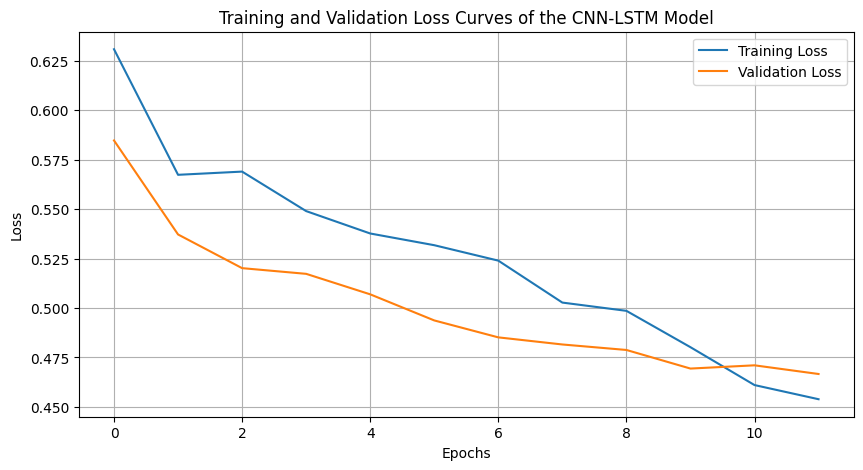

Best Validation Loss: 0.46660656730333966
Best Model Settings: {'dropout': 0.3, 'hidden_dim': 128, 'num_layers': 1}
Test Loss: 0.5066, Test Accuracy: 79.75%


In [ ]:
def plot_loss_curves(training_losses, validation_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Curves of the CNN-LSTM Model')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the loss curves for the best model
plot_loss_curves(best_training_losses, best_validation_losses)
print(f"Best Validation Loss: {best_val_loss}")
print(f"Best Model Settings: {best_model_settings}")

def load_and_evaluate(model_path, test_loader, device):
    checkpoint = torch.load(model_path)
    model = CNNLSTM(
        num_features=24, 
        dropout=checkpoint['dropout'], 
        lstm_hidden_dim=checkpoint['hidden_dim'], 
        num_layers=checkpoint['num_layers']
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.BCEWithLogitsLoss()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            predicted = torch.sigmoid(output).round()
            total += target.size(0)
            correct += (predicted == target).sum().item()
            test_loss += criterion(output, target).item()


    test_loss /= len(test_loader)

    test_accuracy = 100 * correct / total
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

load_and_evaluate('best_model.pth', test_loader, device)

In [ ]:
def evaluate_model(model_path, test_loader, device):
    checkpoint = torch.load(model_path)
    model = CNNLSTM(
        num_features=24, 
        dropout=checkpoint['dropout'], 
        lstm_hidden_dim=checkpoint['hidden_dim'], 
        num_layers=checkpoint['num_layers']
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = torch.sigmoid(output).round()
            all_targets.extend(target.view(-1).tolist())
            all_predictions.extend(prediction.view(-1).tolist())

    precision = precision_score(all_targets, all_predictions)
    return precision

# Calculate precision
model_precision = evaluate_model('best_model.pth', test_loader, device)
print(f'Model Precision: {model_precision:.4f}')

Model Precision: 0.7619


In [95]:
def load_best_model(model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    model = CNNLSTM(
        num_features=24, 
        dropout=checkpoint['dropout'], 
        lstm_hidden_dim=checkpoint['hidden_dim'], 
        num_layers=checkpoint['num_layers']
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

best_model_path = 'best_model.pth'
best_model = load_best_model(best_model_path, device)

# Initialize metrics for binary classification
accuracy = Accuracy(task="BinaryAccuracy", threshold=0.5).to(device)  # Corrected initialization
precision = Precision(task="BinaryAccuracy", threshold=0.5).to(device)
recall = Recall(task="BinaryAccuracy", threshold=0.5).to(device)
f1 = F1Score(task=BinaryAccuracy, threshold=0.5).to(device)

## Evaluate the model on the test set
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = best_model(data)
        preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities

        # Update metrics
        accuracy.update(preds, target.int())
        precision.update(preds, target.int())
        recall.update(preds, target.int())
        f1.update(preds, target.int())

# Compute final metric values
final_accuracy = accuracy.compute()
final_precision = precision.compute()
final_recall = recall.compute()
final_f1 = f1.compute()

print(f"Accuracy: {final_accuracy.item()}")
print(f"Precision: {final_precision.item()}")
print(f"Recall: {final_recall.item()}")
print(f"F1 Score: {final_f1.item()}")

TypeError: Accuracy.__new__() missing 1 required positional argument: 'task'